In [1]:
import mlgrad.risks as risks
import mlgrad.loss as loss
import mlgrad.models as models
import mlgrad.funcs as funcs

from mlgrad import erm_fg, erisk
from mlgrad.regr import m_regression_irls

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [75]:
noise = 0.1
X, Y = datasets.make_moons(n_samples=200, noise=noise, random_state=0)
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

(200, 2) (200,)
float64 int64


In [76]:
Y = Y.astype('d')
Y = 2*Y-1
# Y *= 3.

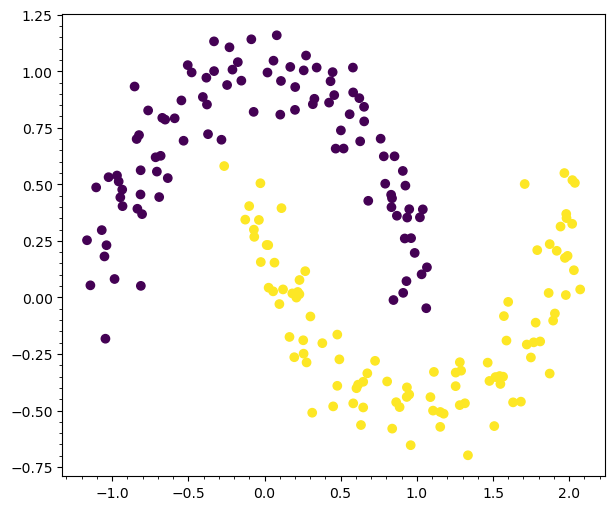

In [77]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:, 1], c=Y)
plt.minorticks_on()
plt.show()

In [78]:
def find_alpha(X, E, mod, W=None):
    Yh = np.array([mod.evaluate_one(Xk) for Xk in X])
    if W is None:
        alpha = np.sum(E * Yh) / np.sum(Yh * Yh)
    else:
        alpha = np.sum(W * E * Yh) / np.sum(W * Yh * Yh)
    return alpha

In [79]:
def find_alpha_cls(X, E, mod, W=None):
    Yh = np.array([mod.evaluate_one(Xk) for Xk in X])
    if W is None:
        alpha = np.sum(E * Yh) / np.sum(Yh * Yh)
    else:
        alpha = np.sum(W * E * Yh) / np.sum(W * Yh * Yh)
    return alpha

In [80]:
def find_param(X, E, mod, loss_func, W=None):
    rs = risks.ERisk(X, E, mod, loss_func)
    if W is not None:
        rs.use_weights(W)
    alg_fg = erm_fg(rs, h=0.01, tol=1.0e-8)

In [81]:
def find_param_alpha(X, Y, lfm, mod, loss_func, n_iter=100, tol=1.0e-6):
    lval = lval_min = np.mean(loss_func.evaluate_all(lfm.evaluate(X), Y))
    alpha_min = alpha = 1
    param_min = mod.param.copy()

    for j in range(n_iter):
        lval_prev = lval

        E = (Y - lfm.evaluate(X)) / alpha
        find_param(X, E, mod, loss_func)
        
        E = np.array([Yk - lfm(Xk) for Xk, Yk in zip(X,Y)])
        alpha = find_alpha(X, E, mod)

        lval = np.mean(loss_func.evaluate_all(lfm.evaluate(X) + alpha*mod.evaluate(X), Y))

        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval

        if j < 2:
            continue
        
        if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
            break

    mod.param[:] = param_min
    alpha = alpha_min
    return alpha        

In [82]:
def gb_fit(X, Y, n_iter=100):
    lfm = models.LinearFuncModel()
    loss_func = loss.SquareErrorLoss()
    lvals = []
    for k in range(n_iter):
        mod = models.SigmaNeuronModel(funcs.Sigmoidal(5.0), X.shape[1])
        mod.init_param()

        a = find_param_alpha(X, Y, lfm, mod, loss_func)
        lfm.add(mod, a)
        # W = np.sum(np.abs(lfm.weights))
        # for i,w in enumerate(lfm.weights):
        #     lfm.weights[i] /= W

        lvals.append(np.mean(loss_func.evaluate_all(lfm.evaluate(X), Y)))
    return lfm, lvals

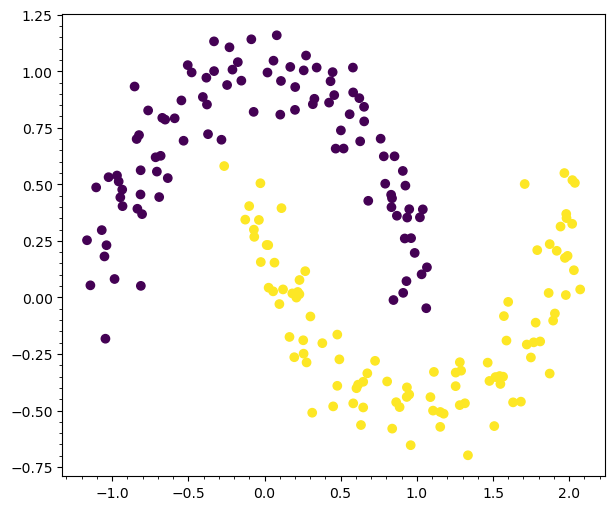

In [83]:
plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:, 1], c=Y)
plt.minorticks_on()
plt.show()

In [84]:
lfm, lvals = gb_fit(X, Y, n_iter=50)
# print(np.asarray(lfm.weights))

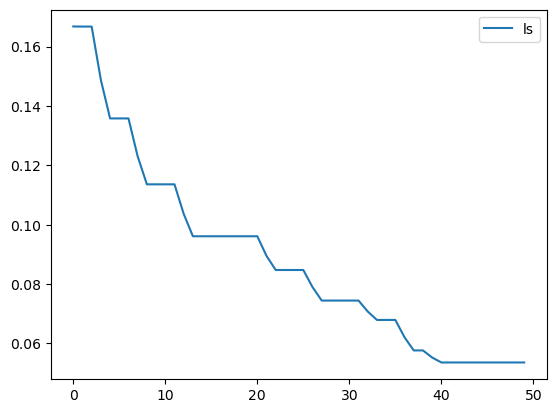

In [85]:
plt.plot(lvals, label='ls')
plt.legend()
plt.show()

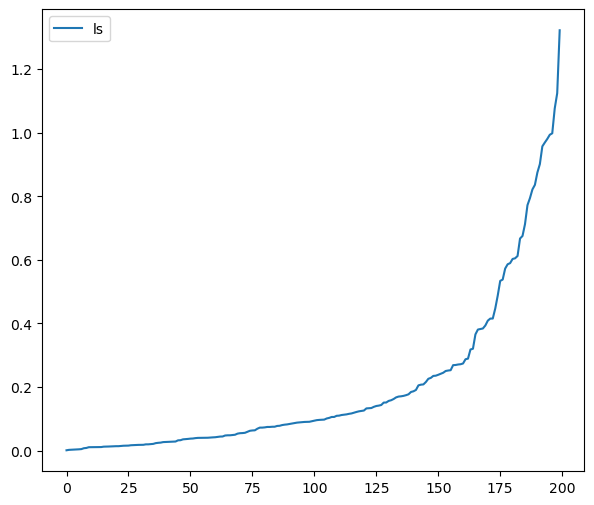

In [86]:
plt.figure(figsize=(7,6))
plt.plot(sorted(abs(lfm.evaluate(X)-Y)), label='ls')
plt.legend()
plt.show()

In [87]:
Y_ls = np.sign(lfm.evaluate(X))
acc_ls = 100*round(metrics.accuracy_score(Y, Y_ls), 3)
print(acc_ls)

98.5


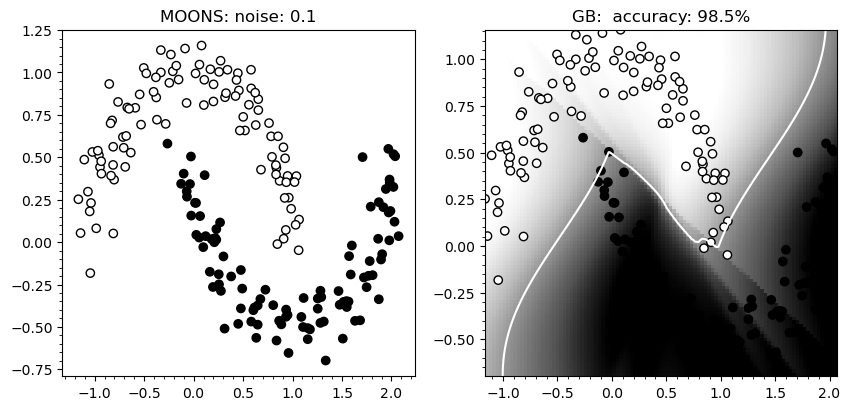

In [88]:
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xrange = np.linspace(x_min, x_max, 100)
yrange = np.linspace(y_min, y_max, 100)
XX, YY = np.meshgrid(xrange, yrange)
X2 = np.c_[XX.ravel(), YY.ravel()]
Z2_ls = lfm.evaluate(X2)
np.putmask(Z2_ls, Z2_ls > 1, 1) 
np.putmask(Z2_ls, Z2_ls < -1, -1) 
ZZ_ls = Z2_ls.reshape(XX.shape)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.title("MOONS: noise: %.1f" % noise)
plt.scatter(X[:,0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Greys)
plt.minorticks_on()
plt.subplot(1,2,2)
plt.title("GB:  accuracy: %.1f%%" % (acc_ls))
plt.scatter(X[:,0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Greys)
cb = plt.imshow(ZZ_ls, aspect='auto', origin='lower', extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
cs = plt.contour(ZZ_ls, levels=[0], extent=(x_min,x_max,y_min,y_max), cmap=plt.cm.Greys)
# plt.clabel(cs, levels=levels)
# plt.colorbar(cb)
plt.minorticks_on()
plt.show()

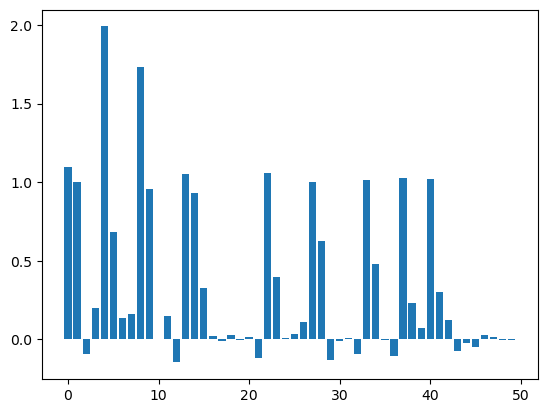

In [89]:
plt.bar(range(len(lfm.weights)), lfm.weights)
plt.show()